In [1]:
import os
from os import path
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
from glob import glob
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import *
import torchvision
from generator import GeneratorRRDB
from trainer_org_running import LitTrainer as LitTrainer_org_running
# from trainer_tune import LitTrainer as LitTrainer_tune
import pytorch_lightning as pl

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)

In [4]:
test_subjects = data_split('test', patients_frac=1)

std = 0.3548

test_set = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading test set...


In [16]:
ckptpath='/mnt/beta/djboonstoppel/Code/ray_results/lr-exp/train_tune_e4b6d_00001_1_learning_rate=0.01_2021-12-23_12-36-06/checkpoints/lr-exp-checkpoint-epoch=34-val_loss=0.0273.ckpt'
model = LitTrainer_org_running.load_from_checkpoint(netG=generator, checkpoint_path=ckptpath)
print(model.hparams)
model.eval()
model.freeze()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/beta/djboonstoppel/Code/ray_results/lr-exp/train_tune_e4b6d_00001_1_learning_rate=0.01_2021-12-23_12-36-06/checkpoints/lr-exp-checkpoint-epoch=34-val_loss=0.0273.ckpt'

In [17]:
batch_size = model.hparams.config['batch_size']

patch_size = (model.hparams.config['patch_size'],model.hparams.config['patch_size'])
ovl_perc = (model.hparams.config['patch_overlap'], model.hparams.config['patch_overlap'])
overlap, nr_patches = calculate_overlap(test_subjects[0]['LR'], patch_size, ovl_perc)

In [18]:
subject = test_set[0]
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size=(*patch_size,1),
    patch_overlap=overlap,
    padding_mode=0,
)

patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=model.hparams.config['batch_size'])

In [19]:
# patch_loader = torch.utils.data.DataLoader(
#     grid_sampler, batch_size=model.hparams.config['batch_size'])
#
# with torch.no_grad():
#     for i, patches_batch in enumerate(patch_loader):
#         if i == 2:
#             imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
#             gen_hr = model(imgs_lr)
# # grid = torch.cat([torch.stack([a*std,b*std,c*std])
# #                   for a,b,c in zip(imgs_lr[120:125],imgs_hr[120:125],gen_hr[120:125])])
# grid = torch.cat([torch.stack([a*std,b*std,c*std])
#                   for a,b,c in zip(imgs_lr[:5],imgs_hr[:5],gen_hr[:5])])
# grid_img = torchvision.utils.make_grid(grid, nrow=3)
# plt.figure(figsize=(10,30))
# plt.imshow(grid_img.permute(1, 2, 0))

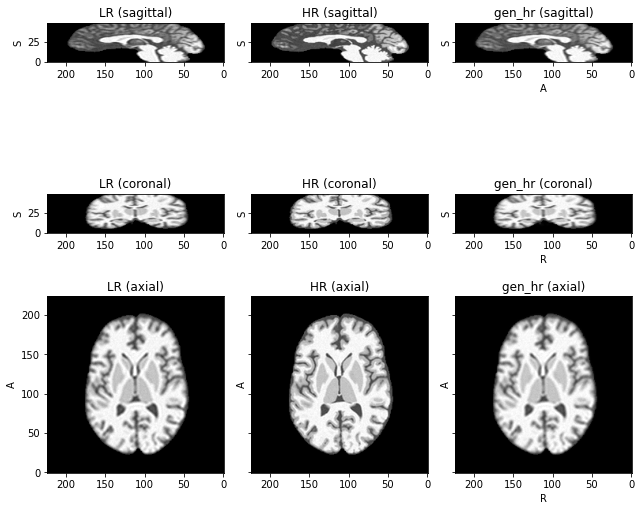

In [20]:
aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
        gen_hr = model(imgs_lr).unsqueeze(4)
        locations = patches_batch[tio.LOCATION]
        aggregator.add_batch(gen_hr, locations)

foreground = aggregator.get_output_tensor()
generated = tio.ScalarImage(tensor=foreground)
subject.add_image(generated, 'gen_hr')
subject.plot(figsize=(9, 8))

In [21]:
# subject['LR'].save('output/lr.nii.gz')
# subject['HR'].save('output/hr.nii.gz')
subject['gen_hr'].save('output/gen-lr:e-2.nii.gz')